<a href="https://colab.research.google.com/github/MarinBallu/regularized-wasserstein-estimator/blob/master/SGD_for_WassEst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pot

     |████████████████████████████████| 430kB 2.7MB/s 


In [ ]:
import numpy as np
import ot
from ot import plot
import matplotlib.pyplot as plt
import math
import random
import timeit
from bisect import bisect_left
from scipy.stats import linregress
import collections

ModuleNotFoundError: ignored

In [ ]:
### INITIALIZATION OF THE ALGORITHM

def cumu_sum(dist):
  ''' Compute the cumulative distribution function for a discrete distribution '''
  n = len(dist)
  cumu_dist = []
  S = 0
  for i in range(n):
      S += dist[i]
      cumu_dist.append(S)
  return np.array(cumu_dist)

def random_int_list(dist, length, replace=True):
  ''' Pick a random list of integers with a given distribution '''
  n = len(dist)
  rand_array = np.random.rand(length)
  i = 0
  cumu_dist = cumu_sum(dist)
  random_list = []
  for x in rand_array:
    i = bisect_left(cumu_dist, x)
    random_list.append(i)
  return random_list

def initialize(a, b, M, numItermax, batch_size):
  ''' Pick the intitial values for the internal variables of the algorithm, and construct the list of random indices to be used for sgd '''
  random_list_a = random_int_list(a, numItermax * batch_size)
  random_list_b = random_int_list(b, numItermax * batch_size)
  n_source = np.shape(M)[0]
  n_target = np.shape(M)[1]
  cur_alpha = np.zeros(n_source)
  cur_beta = np.zeros(n_target)
  cur_S = 1
  alpha_list = []
  beta_list = []
  time_list = []
  return random_list_a, random_list_b, cur_alpha, cur_beta, cur_S, alpha_list, beta_list, time_list

In [ ]:
### INTERMEDIATE COMPUTATIONS FOR THE UPDATES

def dual_to_target(b, reg2, beta):
  ''' compute the target given the dual variable '''
  target = b * np.exp( - beta / reg2)
  target = target / target.sum()
  return target

def partial_target_meas(b, beta, reg2, S):
  ''' Compute one coefficient of the current target measure with one coefficient of the current dual variable, O(1)'''
  nu = b * np.exp(- beta / reg2) / S
  return nu

def partial_grad_dual(b, target, M, reg1, alpha, beta):
  ''' Compute one coefficient of the gradient for the dual variables, O(1) '''
  D = np.exp((alpha + beta - M) / reg1)
  grad_alpha = 1 - D
  grad_beta = target / b  - D
  return grad_alpha, grad_beta

def semi_grad_dual(b, target, M, reg1, alpha, beta):
  ''' Compute the stochastic gradients for the dual variable alpha and full gradient for beta '''
  D = np.exp((alpha + beta - M) / reg1) * b
  grad_alpha = 1 - D.sum()
  grad_beta = target  - D
  return grad_alpha, grad_beta

def sgd_update(b, reg2, alpha, beta, cur_S, grad_alpha, grad_beta, stepsize):
  ''' Update the dual variables as well as the latent memory-conserved variable '''
  cur_S -= b * np.exp(- beta / reg2)
  alpha += stepsize * grad_alpha
  beta += stepsize * grad_beta
  cur_S += b * np.exp(- beta / reg2)
  return alpha, beta, cur_S

def bgd_update(b, reg2, alpha, beta, cur_S, grad_alpha, grad_beta, batch_a, batch_b, stepsize):
  ''' Update the dual variables as well as the latent memory-conserved variable in the batch case '''
  batch_b_unique = list(np.unique(batch_b))
  cur_S -= (b[batch_b_unique] * np.exp(- beta[batch_b_unique] / reg2)).sum()
  for k in range(len(batch_a)):
    alpha[batch_a[k]] += stepsize * grad_alpha[k]
  for k in range(len(batch_b)):
    beta[batch_b[k]] += stepsize * grad_beta[k]
  cur_S += (b[batch_b_unique] * np.exp(- beta[batch_b_unique] / reg2)).sum()
  return alpha, beta, cur_S

In [ ]:
### STOCHASTIC GRADIENT DESCENT

def sgd_entropic_regularization(a, b, M, reg1, reg2, numItermax, lr, maxTime):
  r'''
  Compute the sgd algorithm with one-sized batches to solve the regularized discrete measures
      ot dual estimation problem

  Parameters
  ----------
  a : ndarray, shape (ns,)
      source measure
  b : ndarray, shape (nt,)
      target measure
  M : ndarray, shape (ns, nt)
      cost matrix
  reg1, reg2 : float
      Regularization terms > 0
  numItermax : int
      number of iteration
  lr : float
      learning rate

  Returns
  -------
  alpha : ndarray, shape (ns,)
      dual variable
  beta : ndarray, shape (nt,)
      dual variable
  '''
  # Initialize variables
  random_list_a, random_list_b, cur_alpha, cur_beta, cur_S, alpha_list, beta_list, time_list = initialize(a, b, M, numItermax, 1)
  # Initialize time counter
  start = timeit.default_timer()
  for cur_iter in range(numItermax):
    # Receive the random indices
    i, j = random_list_a[cur_iter], random_list_b[cur_iter]
    # Compute the stepsize
    stepsize = min(lr / np.sqrt(cur_iter + 1), reg1)

    ## SGD
    # Compute gradients
    partial_target = partial_target_meas(b[j], cur_beta[j], reg2, cur_S)
    grad_alpha, grad_beta = partial_grad_dual(b[j], partial_target, M[i, j], reg1, cur_alpha[i], cur_beta[j])
    # Update dual variables
    cur_alpha[i], cur_beta[j], cur_S = sgd_update(b[j], reg2, cur_alpha[i], cur_beta[j], cur_S, grad_alpha, grad_beta, stepsize)
    
    # Update memory for analysis
    alpha_list.append(np.array(cur_alpha))
    beta_list.append(np.array(cur_beta))
    t = timeit.default_timer() - start
    time_list.append(t)

    # Stopping time
    if maxTime and t > maxTime:
      break
  # Stop time counter
  stop = timeit.default_timer()
  # Print info
  print('Nb iter: ', cur_iter + 1)
  print('Time: ', stop - start)  
  print('Average iteration time: ', (stop - start) / numItermax)  
  # Return memory of dual variables and time
  return alpha_list, beta_list, time_list

In [ ]:
### BATCHED GRADIENT DESCENT

def bgd_entropic_regularization(a, b, M, reg1, reg2, numItermax, batch_size, lr, maxTime):
  r'''
  Compute the batched sgd algorithm to solve the regularized discrete measures
      ot dual estimation problem

  Parameters
  ----------
  a : ndarray, shape (ns,)
      source measure
  b : ndarray, shape (nt,)
      target measure
  M : ndarray, shape (ns, nt)
      cost matrix
  reg1, reg2 : float
      Regularization terms > 0
  batch_size : int
      size of the batch
  numItermax : int
      number of iteration
  lr : float
      learning rate

  Returns
  -------
  alpha : ndarray, shape (ns,)
      dual variable
  beta : ndarray, shape (nt,)
      dual variable
  '''
  # Initialize variables
  random_list_a, random_list_b, cur_alpha, cur_beta, cur_S, alpha_list, beta_list, time_list = initialize(a, b, M, numItermax, batch_size)
  # Initialize time counter
  start = timeit.default_timer()
  for cur_iter in range(numItermax):
    # Receive the random batches of indices
    batch_a, batch_b = random_list_a[cur_iter * batch_size : (cur_iter + 1) * batch_size], random_list_b[cur_iter * batch_size : (cur_iter + 1) * batch_size]
    # Compute the stepsize
    stepsize = stepsize = min(lr / np.sqrt(cur_iter + 1), reg1) / batch_size
    
    ## SGD
    # Compute gradients
    partial_target = partial_target_meas(b[batch_b], cur_beta[batch_b], reg2, cur_S)
    grad_alpha, grad_beta = partial_grad_dual(b[batch_b], partial_target, M[batch_a, batch_b], reg1, cur_alpha[batch_a], cur_beta[batch_b])
    # Update dual variables
    cur_alpha, cur_beta, cur_S = bgd_update(b, reg2, cur_alpha, cur_beta, cur_S, grad_alpha, grad_beta, batch_a, batch_b, stepsize)

    # Update memory for analysis
    alpha_list.append(np.array(cur_alpha))
    beta_list.append(np.array(cur_beta))
    t = timeit.default_timer() - start
    time_list.append(t)
    # Stopping time
    if maxTime and t > maxTime:
      break
  # Stop time counter
  stop = timeit.default_timer()
  # Print info
  print('Nb iter: ', cur_iter + 1)
  print('Time: ', stop - start)
  print('Average iteration time: ', (stop - start) / numItermax)
  # Return memory of dual variables and time
  return alpha_list, beta_list, time_list

In [ ]:
### SEMI-STOCHASTIC GRADIENT DESCENT

def ssgd_entropic_regularization(a, b, M, reg1, reg2, numItermax, lr, maxTime):
  r'''
  Compute the semi-sgd algorithm to solve the regularized discrete measures
      ot dual estimation problem (sgd for alpha, full gradient for beta)

  Parameters
  ----------
  a : ndarray, shape (ns,)
      source measure
  b : ndarray, shape (nt,)
      target measure
  M : ndarray, shape (ns, nt)
      cost matrix
  reg1, reg2 : float
      Regularization terms > 0
  batch_size : int
      size of the batch
  numItermax : int
      number of iteration
  lr : float
      learning rate

  Returns
  -------
  alpha : ndarray, shape (ns,)
      dual variable
  beta : ndarray, shape (nt,)
      dual variable
  '''
  # Initialize variables
  random_list_a, useless_random_list_b, cur_alpha, cur_beta, cur_S, alpha_list, beta_list, time_list = initialize(a, b, M, numItermax, 1)
  # Initialize time counter
  start = timeit.default_timer()
  for cur_iter in range(numItermax):
    # Receive the random indices
    i = random_list_a[cur_iter]
    # Compute the stepsize
    stepsize = lr / np.sqrt(cur_iter + 1)

    ## SGD
    # Compute gradients
    target = dual_to_target(b, reg2, cur_beta)
    grad_alpha, grad_beta = semi_grad_dual(b, target, M[i], reg1, cur_alpha[i], cur_beta)
    # Update dual variables
    cur_alpha[i] += stepsize * grad_alpha
    cur_beta += stepsize * grad_beta
    
    # Update memory for analysis
    alpha_list.append(np.array(cur_alpha))
    beta_list.append(np.array(cur_beta))
    t = timeit.default_timer() - start
    time_list.append(t)
    # Stopping time
    if maxTime and t > maxTime:
      break
  # Stop time counter
  stop = timeit.default_timer()
  # Print info
  print('Nb iter: ', cur_iter + 1)
  print('Time: ', stop - start)  
  print('Average iteration time: ', (stop - start) / numItermax)  
  # Return memory of dual variables and time
  return alpha_list, beta_list, time_list

In [ ]:
### AVERAGING ALGORITHM

def avg_variable_list(list1):
  ''' Compute a list of the averages of all the items of a list '''
  list2 = [list1[0]]
  for i in range(len(list1))[1:]:
      tau = 1/(i + 1)
      list2.append(tau * list1[i] + (1 - tau) * list2[-1])
  return list2

def solve_dual_entropic(a, b, M, reg1, reg2, numItermax=10000, batch_size=1, lr=1, maxTime=None):
    r'''
    Compute the transportation matrix to solve the regularized discrete measures
        ot dual estimation problem

    Parameters
    ----------
    a : ndarray, shape (ns,)
        source measure
    b : ndarray, shape (nt,)
        target measure
    M : ndarray, shape (ns, nt)
        cost matrix
    reg1, reg2 : float
        Regularization terms > 0
    batch_size : int
        size of the batch
    numItermax : int
        number of iteration
    lr : float
        learning rate
    maxTime : float
        maximum run time for the gradient loop

    Returns
    -------
    '''
    if batch_size == 0:
      alpha_list, beta_list, time_list = ssgd_entropic_regularization(a, b, M, reg1, reg2, numItermax, lr, maxTime)
    elif batch_size == 1:
      alpha_list, beta_list, time_list = sgd_entropic_regularization(a, b, M, reg1, reg2, numItermax, lr, maxTime)
    else:
      alpha_list, beta_list, time_list = bgd_entropic_regularization(a, b, M, reg1, reg2, numItermax, batch_size, lr, maxTime)
    avg_alpha_list = avg_variable_list(alpha_list)
    avg_beta_list = avg_variable_list(beta_list)
    return avg_alpha_list, avg_beta_list, time_list

In [ ]:
### PERFORMANCE MEASURES FOR GRAPHS AND MISC

def norm_grad_dual(a, b, target, M, reg, alpha, beta):
    r'''
    Compute the gradient L1 norm of the dual optimal transport problem.
    '''
    D = np.exp((alpha[:, None] + beta[None, :] - M[:,:]) / reg) * a[:, None] * b[None, :]
    grad_alpha = (a - D.sum(1))
    grad_beta = (target  - D.sum(0))
    return np.sqrt(np.linalg.norm(grad_alpha)**2 + np.linalg.norm(grad_beta)**2)

def scalar_loss(a, b, M, reg1, reg2, alpha, beta):
  ''' compute the scalar loss of the classical ot problem'''
  target = dual_to_target(b, reg2, beta)
  pi = (np.exp((alpha[:, None] + beta[None, :] - M[:, :]) / reg1) * a[:, None] * target[None, :])
  pi = pi/pi.sum()
  return (M * pi).sum()

def reg1_loss(a, b, M, reg1, reg2, alpha, beta):
  ''' compute the optimization loss of the current target compared to the uniform law '''
  target = dual_to_target(b, reg2, beta)
  pi = (np.exp((alpha[:, None] + beta[None, :] - M[:, :]) / reg1) * a[:, None] * target[None, :])
  pi = pi/pi.sum()
  return (np.log((pi == 0) + pi / (a[:, None] * b[None, :])) * pi).sum()

def reg2_loss(a, b, M, reg1, reg2, alpha, beta):
  ''' compute the kl loss of the current target compared to the uniform law '''
  target = dual_to_target(b, reg2, beta)
  return ((np.log((target == 0) + target / b)) * target).sum()

def kl_div(a, b):
  return ((np.log((a == 0) + a / b)) * a).sum()

In [ ]:
### DISPLAY OF GRAPHS

def graph_loglog(list0, time=[]):
  ''' draw a log-log graph '''
  if not time:
    time = list(range(len(list0)))
  start = 0
  end = len(list0)
  list1 = [np.log(i+1) for i in range(end - start)]
  list2 = [np.log(gn) for gn in list0[start:]]
  slope, intercept, r_value, p_value, std_err = linregress(list1, list2)
  plt.plot(time, list0[start:])
  plt.xscale('log')
  plt.yscale('log')
  plt.grid()
  print('Convergence slope:', slope)

def performance_graphs(a, b, M, reg1, reg2, avg_alpha_list, avg_beta_list, time_list):
  alpha_fin = avg_alpha_list[-1]
  beta_fin = avg_beta_list[-1]
  G = np.exp((alpha_fin[:, None] + beta_fin[None, :] - M) / reg1) * a[:, None] * b[None, :]
  pi = G / G.sum()
  fig, ax = plt.subplots()
  ax.matshow(pi, cmap=plt.cm.Blues)
  plt.axis('off')
  print("Transportation matrix")
  plt.show()

  #scalar_list = [scalar_loss(a, b, M, reg1, reg2, avg_alpha_list[i], avg_beta_list[i]) for i in range(len(avg_alpha_list))]
  #m = min(scalar_list)
  #scalar_list = [(a - m + (scalar_list[-2] - scalar_list[-1]) * numItermax / 2) for a in scalar_list]
  #graph_loglog(scalar_list, 'scalar value')

  #plt.show()
  #reg1_list = [reg1_loss(a, b, M, reg1, reg2, avg_alpha_list[i], avg_beta_list[i]) for i in range(len(avg_alpha_list))]
  #graph_loglog(reg1_list, 'first regularizer')
  #reg2_list = [reg2_loss(a, b, M, reg1, reg2, avg_alpha_list[i], avg_beta_list[i]) for i in range(len(avg_alpha_list))]
  #graph_loglog(reg2_list, 'second regularizer')

  n_source = np.shape(M)[0]
  n_target = np.shape(M)[1]
  target_list = [dual_to_target(b, reg2, beta) for beta in avg_beta_list]
  barWidth = 0.4
  r1 = list(range(n_source))
  r2 = [x + barWidth for x in r1]
  bar1 = a
  bar2 = target_list[-1]
  plt.bar(r1, bar1, width=barWidth)
  plt.bar(r2, bar2, width=barWidth)
  print("Target measure and estimate")
  plt.show()

  grad_norm_list = [norm_grad_dual(a, b, target_list[i], M, reg1, avg_alpha_list[i], avg_beta_list[i]) for i in range(len(avg_alpha_list))]
  print("Final gradient norm:", grad_norm_list[-1])
  graph_loglog(grad_norm_list)
  print("Convergence rate of the gradient norm")
  plt.show()

Cost matrix


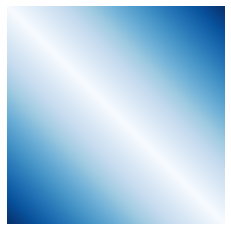

Target measure


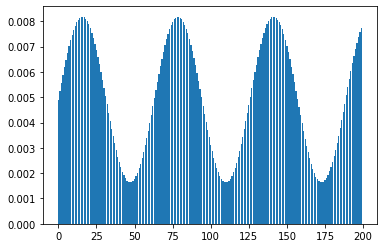

In [ ]:
### INITIALIZE TEST

# set seed
np.random.seed(0)

# set dimension
n_source = 200
n_target = 200

# set target measure
#a = np.ones(n_source)
#a = a/a.sum()
a = 1.5 + np.sin([1*(k / n_source) * 20 for k in range(n_source)]) 
a = a / a.sum()

# set prior measure
b = np.ones(n_target)
b = b/b.sum()

# random distance matrix
# rng = np.random.RandomState(0)
# X_source = rng.randn(n_source, 2)
# Y_target = rng.randn(n_target, 2)
# M = ot.dist(X_source, Y_target)

# discrete distance
# M = (np.ones(n_source) - np.identity(n_source))

# distance on the line
X_source = np.array([k for k in range(n_source)])
Y_target = X_source
M = abs(X_source[:,None] - Y_target[None, :])

# normalize distance matrix (optional)
M = M / (M.max() - M.min())

# make distance matrix positive (mandatory!)
M = M - M.min()

# graph of matrix and target measure
fig, ax = plt.subplots()
print("Cost matrix")
ax.imshow(M, cmap=plt.cm.Blues)
plt.axis('off')
plt.show()
print("Target measure")
plt.bar(range(n_source), a)
plt.show()

Nb iter:  1000000
Time:  16.711197787999993
Average iteration time:  1.6711197787999994e-05
Transportation matrix


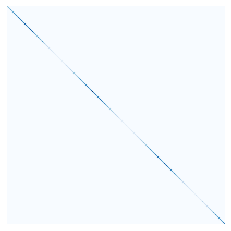

Target measure and estimate


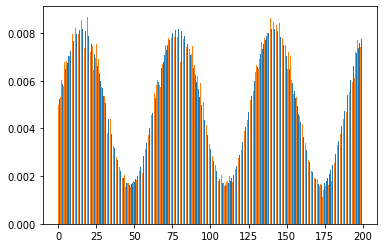

Final gradient norm: 0.026837277330318713
Convergence slope: -0.339983484058397
Convergence rate of the gradient norm


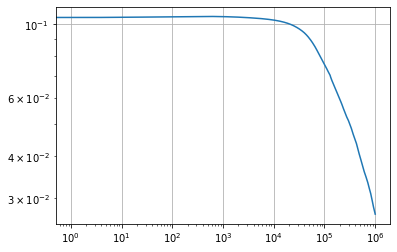

In [ ]:
### PERFORMANCE TEST
# set seed
np.random.seed(1)
# set regularizer parameter
reg1 = 0.002
reg2 = 0.001
# set learning rate (reg1 is close to optimal, using a bigger one might make it diverge)
lr = reg1
# set batch size (0 means use of full gradient in beta, while stochastic in alpha)
batch_size = 1
# set algorithmic parameters (count between 10000 and 70000 iterations per seconds)
numItermax = 1000000
maxTime = 100

avg_alpha_list, avg_beta_list, time_list = solve_dual_entropic(a, b, M, reg1, reg2, numItermax, batch_size, lr, maxTime)
performance_graphs(a, b, M, reg1, reg2, avg_alpha_list, avg_beta_list, time_list)

In [ ]:
def generate_var(n_source, n_target):
  X_source = rng.randn(n_source, 3)
  Y_target = rng.randn(n_target, 3)
  M = ot.dist(X_source, Y_target)
  M = M / (M.max() - M.min())
  M = M - M.min()
  a = np.ones(n_source)/n_source
  b = np.ones(n_target)/n_target
  return X_source, Y_target, M, a, b

In [ ]:
batch_size = 1
np.random.seed(6)
reg1 = 0.05
reg2 = 0.05
lr = reg1
numItermax = 1000000
list_dimensions = [[10, 10], [10,50], [50, 10], [50, 50]]
list_results_alpha, list_results_beta = [], []
rng = np.random.RandomState(0)
for D in list_dimensions:
  n_source = D[0]
  n_target = D[1]
  X_source, Y_target, M, a, b = generate_var(n_source, n_target)
  avg_alpha_list, avg_beta_list, time_list = solve_dual_entropic(a, b, M, reg1, reg2, numItermax, batch_size, lr, maxTime)
  target_list = [dual_to_target(b, reg2, beta) for beta in avg_beta_list]
  norm0 = norm_grad_dual(a, b, target_list[0], M, reg1, avg_alpha_list[0], avg_beta_list[0])
  grad_norm_list = [norm_grad_dual(a, b, target_list[i], M, reg1, avg_alpha_list[i], avg_beta_list[i])/norm0 for i in range(len(avg_alpha_list))]
  print("Final gradient norm:", grad_norm_list[-1])
  graph_loglog(grad_norm_list)
labels=['I = ' + str(D[0]) + ', J = ' + str(D[1]) for D in list_dimensions]
plt.grid()
plt.ylabel('Gradient norm', fontsize=12)
plt.xlabel('Number of iterations', fontsize=12)
plt.legend(labels)
plt.show()

Nb iter:  1000000
Time:  17.51707870000064
Average iteration time:  1.751707870000064e-05


KeyboardInterrupt: ignored

In [ ]:
def compare_results(list_results_alpha, list_results_beta):
  for j in range(len(list_results_alpha)):
    avg_alpha_list =  list_results_alpha[j]
    avg_beta_list =  list_results_beta[j]
    target_list = [dual_to_target(b, reg2, beta) for beta in avg_beta_list]
    error_list = [kl_div(a, target_list[i]) for i in range(len(avg_alpha_list))]
    print("Final error:", error_list[-1])
    graph_loglog(error_list)
    labels=['c = 0.5', 'c = 1', 'c = 2', 'c = 4', 'c = 8']
    plt.legend(labels)
    plt.ylabel('KL Loss', fontsize=12)
    plt.xlabel('Number of iterations', fontsize=12)
    print("Convergence rate of the gradient norm")
  plt.show()

Nb iter:  1000000
Time:  16.96620671799974
Average iteration time:  1.696620671799974e-05
Nb iter:  1000000
Time:  16.713265155000045
Average iteration time:  1.6713265155000045e-05
Nb iter:  1000000
Time:  16.66108924999935
Average iteration time:  1.666108924999935e-05


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


Nb iter:  1000000
Time:  16.71387533699999
Average iteration time:  1.671387533699999e-05


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


Nb iter:  1000000
Time:  16.658656546000202
Average iteration time:  1.6658656546000202e-05
Final error: 0.10961861534556983
Convergence slope: 0.39028157683160086
Convergence rate of the gradient norm
Final error: 0.12870020630182277
Convergence slope: 0.2203638461614534
Convergence rate of the gradient norm
Final error: 0.13816578454060136
Convergence slope: 0.1076612914596059
Convergence rate of the gradient norm


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


Final error: nan
Convergence slope: nan
Convergence rate of the gradient norm


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


Final error: nan
Convergence slope: nan
Convergence rate of the gradient norm


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


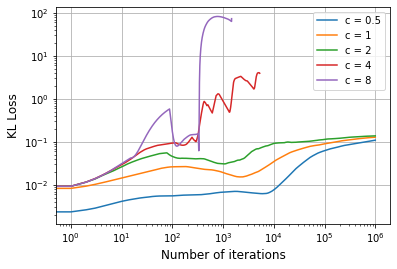

In [ ]:
numItermax = 1000000
np.random.seed(6)
avg_alpha_list1, avg_beta_list1, time_list1 = solve_dual_entropic(a, b, M, reg1, reg2, numItermax, batch_size, lr/2, maxTime)
avg_alpha_list2, avg_beta_list2, time_list2 = solve_dual_entropic(a, b, M, reg1, reg2, numItermax, batch_size, lr, maxTime)
avg_alpha_list3, avg_beta_list3, time_list3 = solve_dual_entropic(a, b, M, reg1, reg2, numItermax, batch_size, 2*lr, maxTime)
avg_alpha_list4, avg_beta_list4, time_list4 = solve_dual_entropic(a, b, M, reg1, reg2, numItermax, batch_size, 4*lr, maxTime)
avg_alpha_list5, avg_beta_list5, time_list5 = solve_dual_entropic(a, b, M, reg1, reg2, numItermax, batch_size, 4*lr, maxTime)
list_results_alpha = [avg_alpha_list1, avg_alpha_list2, avg_alpha_list3, avg_alpha_list4, avg_alpha_list5]
list_results_beta = [avg_beta_list1, avg_beta_list2, avg_beta_list3, avg_beta_list4, avg_beta_list5]
compare_results(list_results_alpha, list_results_beta)

In [ ]:
### PREPARE FOR ANIMATION

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

target_list = [dual_to_target(b, reg2, beta) for beta in avg_beta_list[:50000]]

#def transport_map(alpha, beta, M, reg1, a, b):
#  G = np.exp((alpha[:, None] + beta[None, :] - M) / reg1) * a[:, None] * b[None, :]
#  return G / G.sum()

#transport_map_list = [transport_map(avg_alpha_list[i], avg_beta_list[i], M, reg1, a, b) for i in range(numItermax)]

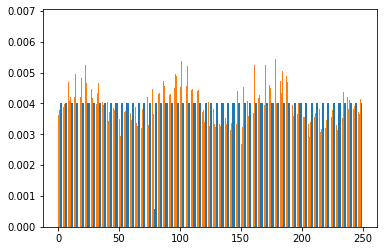

In [ ]:
# ANIMATION OF THE TARGET MEASURE

fig=plt.figure()
# Number of frames (100 frames per second)
n = 1000

k = int(len(target_list)) // n
barWidth = 0.4

r1 = np.arange(n_source)
r2 = [x + barWidth for x in r1]
barcollection = plt.bar(r1, target_list[0], width=barWidth)
barcollection1 = plt.bar(r2, target_list[-1], width=barWidth)
plt.ylim(0, np.max(target_list[-1])*1.1)

def animate(t):
    y=target_list[t * k]
    for i, b in enumerate(barcollection):
        b.set_height(y[i])

anim=animation.FuncAnimation(fig, animate, repeat=False, blit=False, frames=n,
                             interval=10)

HTML(anim.to_html5_video())

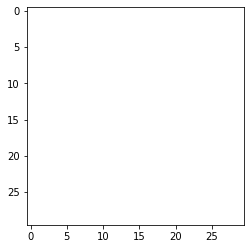

In [ ]:
# ANIMATION OF THE TRANSPORT MAP
fig=plt.figure()
# Number of frames (100 frames per second)
n = 500

k = len(transport_map_list) // n
ims = []
for i in range(n):
    im = plt.imshow(transport_map_list[i*k], animated=True, cmap=plt.cm.Blues)
    ims.append([im])
anim2 = animation.ArtistAnimation(fig, ims, repeat=False, blit=False,
                             interval=10)

HTML(anim2.to_html5_video())

ValueError: ignored

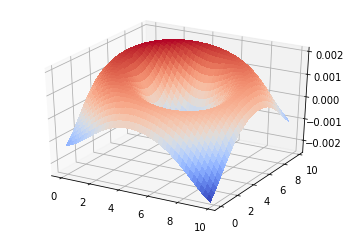

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(0, 10, 0.25)
Y = np.arange(0, 10, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt((X-5)**2 + (Y-5)**2)/1.2
Z = -np.cos(R) + (Y - X) /10
Z = Z/Z.sum()



# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, max(Z))
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [18]:
%cd /root/

/root
